In [52]:
## Data import
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Read data and drop nan's
df_full = pd.read_excel('../data/dataset.xls')
df_full.FlightNumber = df_full.FlightNumber.astype(object)
# df_full.SeatCapacity = df_full.SeatCapacity.astype(object)
df = df_full.dropna()

## Split time into usable data
df['Year'] = df.ScheduleTime.dt.year.astype(object);
df['Month'] = df['ScheduleTime'].dt.month.astype(object);
df['WeekNumber'] = df['ScheduleTime'].dt.isocalendar().week % 52;
df['Weekday'] = df['ScheduleTime'].dt.dayofweek + 1;
df.WeekNumber = df.WeekNumber.astype(object);
df.Weekday = df.Weekday.astype(object);
df['HourOfDay'] = df['ScheduleTime'].dt.hour.astype(object);
df['MinuteOfHour'] = df['ScheduleTime'].dt.minute.astype(object);

## Define feature columns
feature_cols = ['Airline', 'FlightNumber', 'Destination', 'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'Year', 'Month', 'WeekNumber', 'Weekday', 'HourOfDay', 'MinuteOfHour']
under_15_cols = ['FlightType', 'Sector', 'Year', 'Month', 'Weekday', 'MinuteOfHour']
over_15_cols = ['Airline', 'FlightNumber', 'Destination', 'AircraftType', 'WeekNumber', 'HourOfDay']
nominal_cols = ['Airline', 'FlightNumber', 'Destination', 'AircraftType', 'FlightType', 'Sector', 'Year', 'Month', 'WeekNumber', 'Weekday', 'HourOfDay', 'MinuteOfHour']
ordinal_cols = ['SeatCapacity']
df

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor,Year,Month,WeekNumber,Weekday,HourOfDay,MinuteOfHour
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,0.408451,2021,1,1,5,6,35
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,0.189189,2021,1,1,5,10,35
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,0.570423,2021,1,1,5,12,5
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,0.333333,2021,1,1,5,13,20
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,0.204301,2021,1,1,5,14,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36765,2022-02-08 18:30:00,VW,986,YYZ,320,J,CA,180,0.522222,2022,2,6,2,18,30
36766,2022-02-08 19:30:00,LJ,579,YQU,319,J,CA,156,0.532051,2022,2,6,2,19,30
36767,2022-02-08 19:40:00,LJ,506,YUL,319,J,CA,156,0.602564,2022,2,6,2,19,40
36768,2022-02-08 19:05:00,CL,2708,DAN,73H,J,US,189,0.417989,2022,2,6,2,19,5


# Data analysis

In [61]:
import matplotlib.pyplot as plt
import numpy as np

## First we want to plot different fatures over time

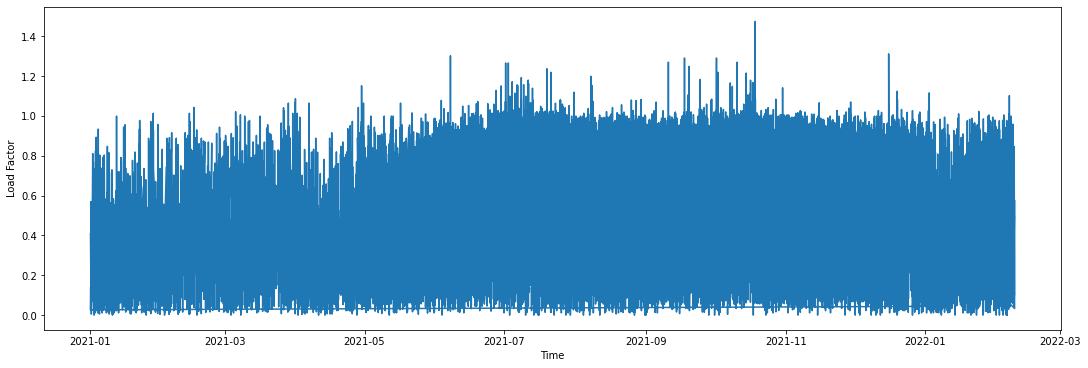

In [38]:
### Let's try plotting the loadfactor
fig, ax = plt.subplots(1, 1, figsize=(15, 5), constrained_layout=True)
ax.set_xlabel('Time')
ax.set_ylabel('Load Factor')
ax.plot(df.ScheduleTime, df.LoadFactor)

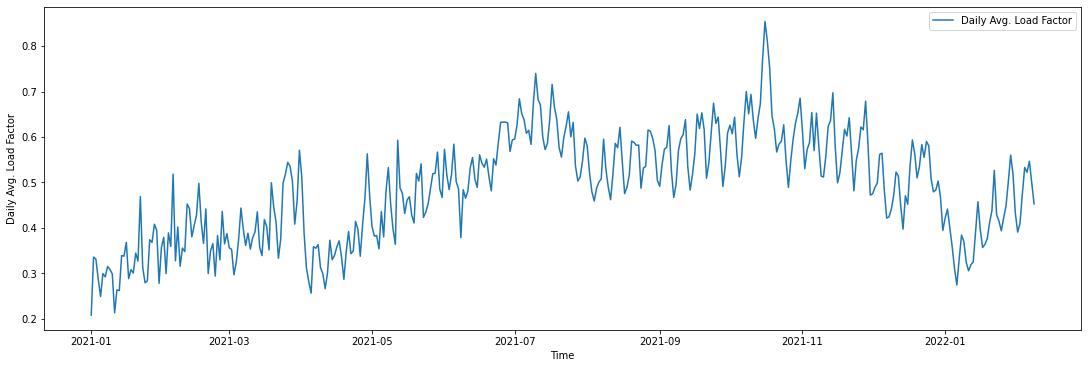

In [71]:
### Obviously, this is confusing and yields no information.. Lets try the daily average load factor
fig, ax = plt.subplots(1, 1, figsize=(15, 5), constrained_layout=True)
ax.set_xlabel('Time')
ax.set_ylabel('Daily Avg. Load Factor')

df_daily_avg = df.groupby(df.ScheduleTime.dt.date).mean()
df_daily_avg.reset_index(level=0, inplace=True)
df_daily_avg
ax.plot(df_daily_avg.ScheduleTime, df_daily_avg.LoadFactor, label="Daily Avg. Load Factor")
plt.legend()


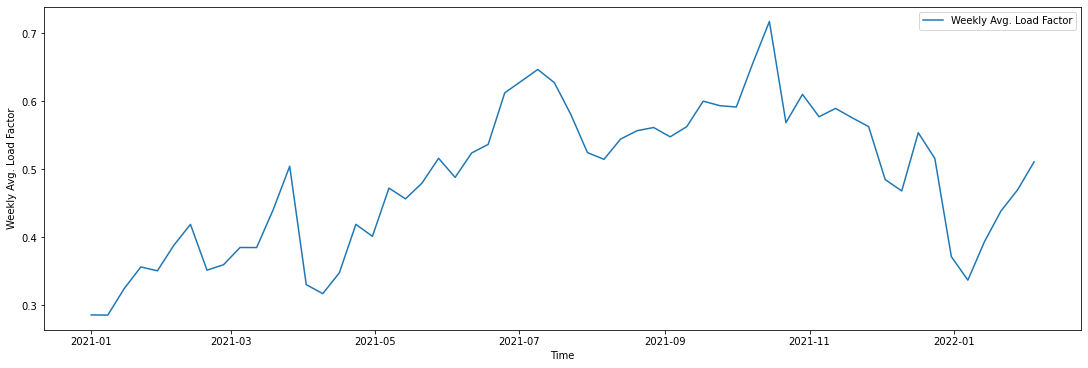

In [75]:
### While the daily average show some more signal, it seems impacted by weekly fluctuations.. Lets try weekly avg
fig, ax = plt.subplots(1, 1, figsize=(15, 5), constrained_layout=True)
ax.set_xlabel('Time')
ax.set_ylabel('Weekly Avg. Load Factor')


df_weekly_avg = df_daily_avg.groupby(np.arange(len(df_daily_avg))//7).mean()
df_weekly_avg['ScheduleTime'] = df_daily_avg.ScheduleTime.groupby(np.arange(len(df_daily_avg))//7).first()
# df_weekly_avg.reset_index(level=0, inplace=True)

df_weekly_avg
ax.plot(df_weekly_avg.ScheduleTime, df_weekly_avg.LoadFactor, label="Weekly Avg. Load Factor")
plt.legend()

### What we see from the average load factors is a somewhat large rise over the autumn-christmas period

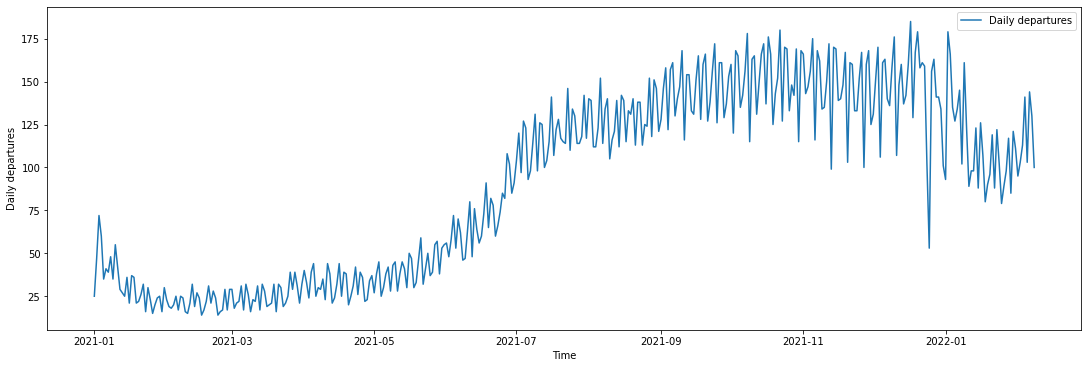

In [94]:
### We inspect the number of daily departures over the duration of the data
fig, ax = plt.subplots(1, 1, figsize=(15, 5), constrained_layout=True)
ax.set_xlabel('Time')
ax.set_ylabel('Daily departures')

df_daily_count = df.groupby(df.ScheduleTime.dt.date).count()
del df_daily_count['ScheduleTime']
df_daily_count.reset_index(level=0, inplace=True)
df_daily_count
ax.plot(df_daily_count.ScheduleTime, df_daily_count.LoadFactor, label="Daily departures")
plt.legend()

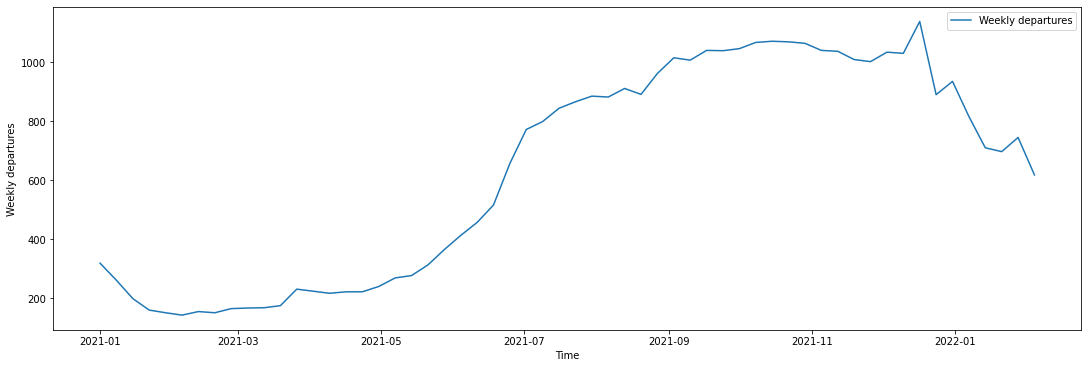

In [91]:
### Same, but for weekly departures
fig, ax = plt.subplots(1, 1, figsize=(15, 5), constrained_layout=True)
ax.set_xlabel('Time')
ax.set_ylabel('Weekly departures')

df_daily_count = df.groupby(df.ScheduleTime.dt.date).count()
del df_daily_count['ScheduleTime']
df_daily_count.reset_index(level=0, inplace=True)
df_daily_count

df_weekly_count = df_daily_count.groupby(np.arange(len(df_daily_count))//7).sum()
df_weekly_count['ScheduleTime'] = df_daily_count.ScheduleTime.groupby(np.arange(len(df_daily_count))//7).first()
df_weekly_count
ax.plot(df_weekly_count.ScheduleTime, df_weekly_count.LoadFactor, label="Weekly departures")
plt.legend()

### The number of departures, especially when looking at the weekly-ploted, clearly shows a rise in departures starting in summer and leveling out over autumn-christimas. This seemingly correlates with the avg load factor, maybe these are in fact correlated..

In [96]:
### Computing correlation between avg. load factors and number of departures

day_corr = df_daily_avg.LoadFactor.corr(df_daily_count.LoadFactor)
print(f'Correlation between daily average Load Factor and dayly departures: {day_corr}')

week_corr = df_weekly_avg.LoadFactor.corr(df_weekly_count.LoadFactor)
print(f'Correlation between weekly average Load Factor and dayly departures: {week_corr}')

Correlation between daily average Load Factor and dayly departures: 0.6651508116421021
Correlation between weekly average Load Factor and dayly departures: 0.7411544699389545


### In fact, the average load factor is correlated much with the number of departures. 